In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
# Define dataset parameters
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50


In [3]:
# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
# Split the dataset into training, validation, and test sets
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [5]:

# Preprocess the data for DenseNet
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

train_ds = train_ds.map(lambda x, y: (resize_and_rescale(data_augmentation(x)), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

In [6]:
# Define and build the DenseNet model
base_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    pooling='avg',
    classes=len(dataset.class_names)
)

for layer in base_model.layers:
    layer.trainable = False

densenet_model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(dataset.class_names), activation='softmax')
])


29084464/29084464 [==============================] - 10s 0us/step


In [7]:
# Compile the DenseNet model
densenet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [8]:
# Train the DenseNet model
history_densenet = densenet_model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 212s 4s/step - loss: 0.4138 - accuracy: 0.8592 - val_loss: 0.1919 - val_accuracy: 0.9375
Epoch 2/50
54/54 [==============================] - 197s 4s/step - loss: 0.1388 - accuracy: 0.9613 - val_loss: 0.1729 - val_accuracy: 0.9464
Epoch 3/50
54/54 [==============================] - 201s 4s/step - loss: 0.1057 - accuracy: 0.9676 - val_loss: 0.0907 - val_accuracy: 0.9635
Epoch 4/50
54/54 [==============================] - 199s 4s/step - loss: 0.0814 - accuracy: 0.9783 - val_loss: 0.0817 - val_accuracy: 0.9844
Epoch 5/50
54/54 [==============================] - 202s 4s/step - loss: 0.0660 - accuracy: 0.9818 - val_loss: 0.0544 - val_accuracy: 0.9792
Epoch 6/50
54/54 [==============================] - 200s 4s/step - loss: 0.0487 - accuracy: 0.9842 - val_loss: 0.0385 - val_accuracy: 1.0000
Epoch 7/50
54/54 [==============================] - 200s 4s/step - loss: 0.0429 - accuracy: 0.9894 - val_loss: 0.0315 - val_accuracy: 0.9896
Epoch 8/50
54

In [9]:
# Evaluate the DenseNet model on the test set
densenet_scores = densenet_model.evaluate(test_ds)

8/8 [==============================] - 29s 3s/step - loss: 0.0129 - accuracy: 0.9961


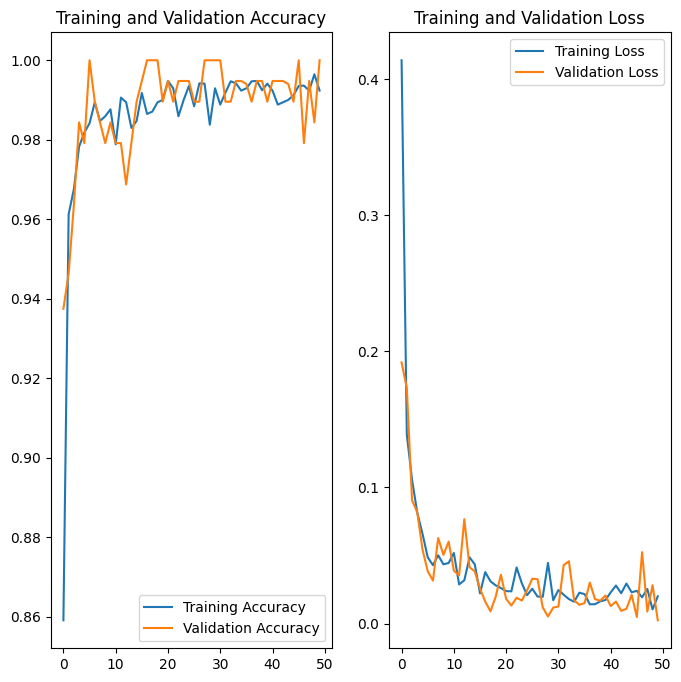

In [10]:
# Visualize training and validation curves for the DenseNet model
densenet_acc = history_densenet.history['accuracy']
densenet_val_acc = history_densenet.history['val_accuracy']

densenet_loss = history_densenet.history['loss']
densenet_val_loss = history_densenet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), densenet_acc, label='Training Accuracy')
plt.plot(range(EPOCHS), densenet_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), densenet_loss, label='Training Loss')
plt.plot(range(EPOCHS), densenet_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
# Print evaluation scores for the DenseNet model
print("Test Loss:", densenet_scores[0])
print("Test Accuracy:", densenet_scores[1])

Test Loss: 0.012891281396150589
Test Accuracy: 0.99609375
